In [140]:
import numpy as np
import pandas as pd
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, rand_score, jaccard_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_predict
from sklearn.svm import SVC

## Task 6 - Text Clustering as a Proxy for Ground Truth

Once again, we will use the cleaned reviews dataset from Task 1.

In [79]:
reviews = pd.read_csv('cleaned_reviews.csv')["review"]

## 6.1. Topic Modelling with LDA

We first need to vectorize the text data. We will use a `CountVectorizer` to convert the text into a bag-of-words model, filtering out very common and very rare words.

In [80]:
vectorizer = CountVectorizer(max_df=0.9, min_df=5, stop_words='english')
X_counts = vectorizer.fit_transform(reviews)

Next, we use LDA to find topics in the reviews.

The value for number of topics was set to 4 after some brief trial and error. This is not a hard limit, but it seems to work well for this dataset.

I've set my RGU ID as the random state for reproducibility.

In [81]:
n_topics = 4

lda = LatentDirichletAllocation(n_components=n_topics, random_state=2506673) # This is my RGU ID lol
lda.fit(X_counts)

,n_components,4
,doc_topic_prior,None
,topic_word_prior,None
,learning_method,'batch'
,learning_decay,0.7
,learning_offset,10.0
,max_iter,10
,batch_size,128
,evaluate_every,-1
,total_samples,1000000.0
,perp_tol,0.1


Next, for each topic, we will find the words that are most unique to that topic compared to the others. This will help us understand what each topic is about.

In [82]:
n_top_words = 15

topic_word = lda.components_
feature_names = vectorizer.get_feature_names_out()

for topic_idx in range(n_topics):
    # Mean of other topics
    other_topics = np.delete(topic_word, topic_idx, axis=0)
    diff = topic_word[topic_idx] - other_topics.mean(axis=0)
    top_indices = np.argsort(diff)[-n_top_words:][::-1]
    print(f"Words unique to Topic {topic_idx + 1}:")
    print(" ".join([feature_names[i] for i in top_indices]))
    print()

Words unique to Topic 1:
service stay experience thank hospitality special excellent staff amazing wonderful thanks team great highly mr

Words unique to Topic 2:
good nice hotel clean rooms great friendly staff place location helpful pool beach view food

Words unique to Topic 3:
room didnt dont hotel bad water asked night booked said bathroom poor bed dirty worst

Words unique to Topic 4:
beautiful sri house views lovely tea peaceful lanka villa kandy nature lankan relaxing garden perfect



Based on these results, we can assign the topics to the following categories:
- Topic 1 - Positive feedback on hotel staff and hospitality
- Topic 2 - Positive feedback on hotel amenities and services
- Topic 3 - Negative feedback
- Topic 4 - Positive feedback on hotel location and surrounding (indirect to the hotel itself)

 > Note: Regardless of any different combination I tried, I was unable to cluster for topics based on different aspects.

## 6.2. Manual Labeling of Reviews

A random set of 50 reviews were selected, and labelled according to the four topics identified above. The labels were assigned based on the most prominent topic in each review.

In [85]:
labeled_reviews = pd.read_csv('cleaned_reviews_labelled_aspect.csv')
labeled_reviews.head()

,review_id,location_id,hotel_name,city,review,rating,aspect
0,697985229,3220199,Subhas Hotel,Jaffna,landed perfect hotel jaffna located prime loca...,4,4_location
1,1015796423,306381,Ramada by Wyndham Colombo,Colombo,great service stay great inusha madhavi prasan...,5,1_hospitality
2,827297036,5863531,Royal Castle,Negombo,honey moon night stayed two nights honeymoonwe...,5,2_services
3,997068714,23326905,Kenrish Hotel,Wadduwa,wcc 87 al batch getogether exciting moment ken...,5,4_location
4,1015645770,2510666,Jetwing Lagoon Wellness,Negombo,spa jetwing lagoon superb head shoulder foot m...,5,2_services


As seen above, there is a new column added named `aspect`, which contains the topic label for each review.

We can visualize the distribution of these labels to see how many reviews fall into each category.

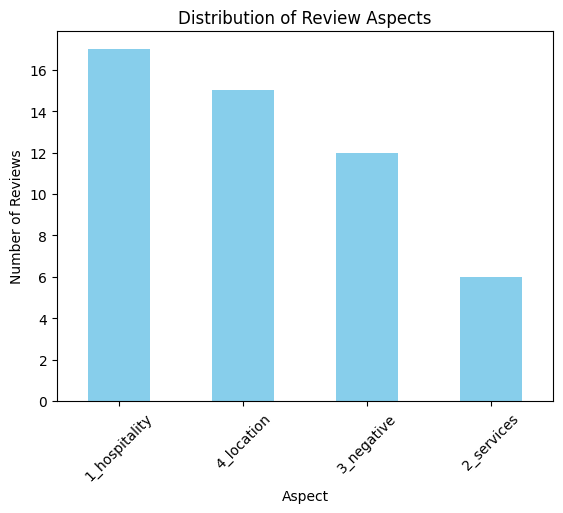

In [86]:
labeled_reviews['aspect'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of Review Aspects')
plt.xlabel('Aspect')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.show()

We can see that this dataset is imbalanced, with the majority of reviews falling into the "1. Positive feedback on hotel staff and hospitality" topic, and with only 5 reviews in the "2. Positive feedback on hotel amenities and services" topic.

### 6.3. Evaluating Clustering with Manual Labels

Now, we will use these manually labeled reviews to validate our clustering results. We will assign the topics identified by LDA to the reviews and compare them with the manually assigned labels.

In [96]:
new_counts = vectorizer.transform(labeled_reviews['review'])
topic_probs = lda.transform(new_counts)
assigned_topics = topic_probs.argmax(axis=1)

labeled_reviews['assigned_topic'] = assigned_topics
labeled_reviews.head()

,review_id,location_id,hotel_name,city,review,rating,aspect,assigned_topic
0,697985229,3220199,Subhas Hotel,Jaffna,landed perfect hotel jaffna located prime loca...,4,4_location,1
1,1015796423,306381,Ramada by Wyndham Colombo,Colombo,great service stay great inusha madhavi prasan...,5,1_hospitality,0
2,827297036,5863531,Royal Castle,Negombo,honey moon night stayed two nights honeymoonwe...,5,2_services,1
3,997068714,23326905,Kenrish Hotel,Wadduwa,wcc 87 al batch getogether exciting moment ken...,5,4_location,3
4,1015645770,2510666,Jetwing Lagoon Wellness,Negombo,spa jetwing lagoon superb head shoulder foot m...,5,2_services,0


Here we can see that the labels assigned by LDA are numerical indices corresponding to the topics. We will map these indices to the topic names for better readability.

In [97]:
labeled_reviews['assigned_topic'] = labeled_reviews['assigned_topic'].astype(str)
labeled_reviews['assigned_topic'] = labeled_reviews['assigned_topic'].map({
    "0": "1_hospitality",
    "1": "2_services",
    "2": "3_negative",
    "3": "4_location"
})

labeled_reviews.head(20)

,review_id,location_id,hotel_name,city,review,rating,aspect,assigned_topic
0,697985229,3220199,Subhas Hotel,Jaffna,landed perfect hotel jaffna located prime loca...,4,4_location,2_services
1,1015796423,306381,Ramada by Wyndham Colombo,Colombo,great service stay great inusha madhavi prasan...,5,1_hospitality,1_hospitality
2,827297036,5863531,Royal Castle,Negombo,honey moon night stayed two nights honeymoonwe...,5,2_services,2_services
3,997068714,23326905,Kenrish Hotel,Wadduwa,wcc 87 al batch getogether exciting moment ken...,5,4_location,4_location
4,1015645770,2510666,Jetwing Lagoon Wellness,Negombo,spa jetwing lagoon superb head shoulder foot m...,5,2_services,1_hospitality
5,889286748,1160171,The Oasis Ayurveda Beach Resort,Hambantota,everything fine good people oasis hotel resort...,5,1_hospitality,3_negative
6,865299810,23587000,Earl's Rajarata,Anuradhapura,great hotel wonderful staff definitely returni...,5,1_hospitality,3_negative
7,1012507426,505588,Berjaya Hotel Colombo,Dehiwala-Mount Lavinia,great stay stay comfortable service welcoming ...,5,1_hospitality,1_hospitality
8,1014148799,316671,Mermaid Hotel & Club,Kalutara,wonderful stay mermaid hotel club went hotel a...,5,1_hospitality,1_hospitality
9,999901918,13336245,Ahas Gawwa,Padukka,quality time ahas gawwa place beautiful staff ...,5,4_location,4_location


Now, we can clearly see the assigned topics for each review. We can compare these with the manually assigned labels to evaluate the clustering performance.

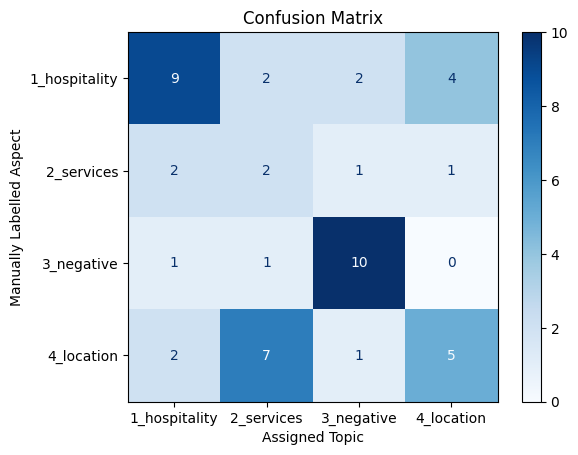

In [105]:
conf_matrix = confusion_matrix(labeled_reviews['aspect'], labeled_reviews['assigned_topic'])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["1_hospitality", "2_services", "3_negative", "4_location"])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Assigned Topic')
plt.ylabel('Manually Labelled Aspect')
plt.show()

As we can see from the confusion matrix, there are a significant number of classifications, especially for the `4_location` topic, that are misclassified as `2_services`. This indicates that the clustering is not perfect and there is some overlap between the topics.

Another explanation for this could be that the topics are not as distinct as we would like them to be, and there is some ambiguity in the reviews that makes it difficult to assign them to a single topic. We faced this same issue while manually labelling the reviews, as some reviews could be classified into multiple topics.

But for `1_hospitality` and `3_negative`, the clustering seems to be more accurate, with fewer misclassifications.

In [107]:
accuracy = accuracy_score(labeled_reviews['aspect'], labeled_reviews['assigned_topic'])
precision = precision_score(labeled_reviews['aspect'], labeled_reviews['assigned_topic'], average='weighted')
recall = recall_score(labeled_reviews['aspect'], labeled_reviews['assigned_topic'], average='weighted')
f1 = f1_score(labeled_reviews['aspect'], labeled_reviews['assigned_topic'], average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.5200
Precision: 0.5600
Recall: 0.5200
F1 Score: 0.5287


Finally, we can summarize the performance of our clustering model using the usual performance metrics. We have an accuracy of 0.52, which is not very high, but it is better than random guessing. The precision, recall, and F1 score are also relatively low, indicating that the model is not performing well in distinguishing between the different topics.

We can also use the Rand Index and Jaccard Coefficient to evaluate the clustering performance.

In [110]:
rand_index = rand_score(labeled_reviews['aspect'], labeled_reviews['assigned_topic'])
print(f"Rand Index: {rand_index:.4f}")

Rand Index: 0.6988


In [119]:
jaccard_coefficient = jaccard_score(labeled_reviews['aspect'], labeled_reviews['assigned_topic'], average="macro")
print(f"Jaccard Coefficient: {jaccard_coefficient:.4f}")

Jaccard Coefficient: 0.3523


For Rand Index, we receive a value of 0.6988, which indicates a moderate level of agreement between the clustering and the manual labels.

For Jaccard Coefficient, we receive a value of 0.3523, which indicates a low level of agreement between the clustering and the manual labels. Since this metric is based on the size of the intersection and union of the sets - we can expect this score to be lower as the dataset is not very distinct and there is a significant amount of overlap between the topics. 

### 6.4. Implementing an Aspect Based Sentiment Classifier 


Now, we can use the LDA model we trained in 6.3, to assign cluster labels for all of the reviews.

In [126]:
reviews = pd.read_csv('cleaned_reviews.csv')

counts = vectorizer.transform(reviews['review'])
topic_probs = lda.transform(counts)
assigned_topics = topic_probs.argmax(axis=1)
reviews["aspect"] = assigned_topics
reviews["aspect"] = reviews["aspect"].astype(str)
reviews["aspect"] = reviews["aspect"].map({
    "0": "1_hospitality",
    "1": "2_services",
    "2": "3_negative",
    "3": "4_location"
})

reviews.head()

,review_id,location_id,hotel_name,city,review,rating,aspect
0,1016464488,11953119,Nh Collection Colombo,Colombo,good stay found lighters toilet paper rolls no...,1,3_negative
1,1016435128,11953119,Nh Collection Colombo,Colombo,definitely recommend hotel excellent food good...,5,2_services
2,1016307864,11953119,Nh Collection Colombo,Colombo,wonderful stay comfortable staycooperative sta...,5,2_services
3,1016165618,11953119,Nh Collection Colombo,Colombo,favorite 4 star hotel colombo live new york ar...,5,2_services
4,1015472232,11953119,Nh Collection Colombo,Colombo,excellent food stay excellent food especially ...,5,1_hospitality


Since in task 3 and 4, we observed that the best performance for the classification model appeared when we used a Word2Vec embeddings with a Support Vector Machine, we will be doing the same for this task as well to create an aspect based sentiment classifier. 

In [154]:
word2vec_data = pd.read_csv('feature_matrix_word2vec.csv')
ground_truth = reviews['aspect'].values

In [155]:
def classifier(features, ground_truth, name, clf):
    y_pred = cross_val_predict(clf, features, ground_truth, cv=5)
    print(f'Accuracy for {name}: {accuracy_score(ground_truth, y_pred):.4f}')
    print(f"Precision for {name}: {precision_score(ground_truth, y_pred, average='weighted'):.4f}")
    print(f"Recall for {name}: {recall_score(ground_truth, y_pred, average='weighted'):.4f}")
    print(f"F1 Score for {name}: {f1_score(ground_truth, y_pred, average='weighted'):.4f}")

    cm = confusion_matrix(ground_truth, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(text_kw={'color': 'black'})
    plt.title(f'Confusion Matrix for {name} Features')
    plt.show()

    return f1_score(ground_truth, y_pred, average='weighted')

And now we can run this model against the established ground truth labels to see how well it performs.

Accuracy for Word2Vec: 0.8988
Precision for Word2Vec: 0.8995
Recall for Word2Vec: 0.8988
F1 Score for Word2Vec: 0.8989


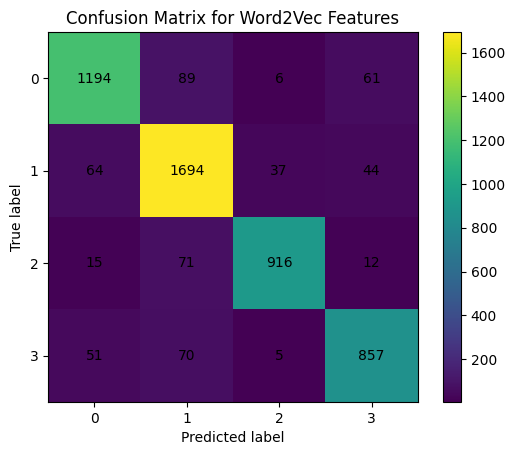

0.898850911982972

In [156]:
classifier(word2vec_data, ground_truth, "Word2Vec", SVC(kernel='linear'))

As it can be seen above, this model performs quite well, with an accuracy and F1-score over 89%. This is expected as the LDA model assigned reviews to a cluster based on the keywords present within it. This model is able to capture that same information quite well. 